In [11]:
# Import Libraries

import pandas as pd
import numpy as np
import string
import re
import requests
import os
import json
import twitter
import tweepy
from pandas.io.json import json_normalize
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import naive_bayes
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Collecting Data to Analyze from Twitter

In [12]:
# function to take the tweepy objects and convert them to json

def jsonify_tweepy(tweepy_object):
    json_str = json.dumps(tweepy_object._json)
    return json.loads(json_str)

# set my api data as strings for building the full url

API_key = 'XXXX'
API_secret = 'XXXX'
bearer_token = 'XXXX'
access_token = 'XXXX'
access_secret = 'XXXX'
auth = tweepy.OAuthHandler(API_key, API_secret)
auth.set_access_token(access_token, access_secret)
tweepy_api = tweepy.API(auth, wait_on_rate_limit=True)

In [27]:
# Selecting a hashtag to search twitter for online payment hashtags and choosing the most recent 5000

h = ('@amazon')
tweets=list(tweepy.Cursor(tweepy_api.search_tweets,q=h, tweet_mode='extended').items(5000))
tweet_list = [jsonify_tweepy(t) for t in tweets]
df_amz = pd.json_normalize(tweet_list)

In [29]:
# Taking the various dataframes made in the previous cell and concatenating them

frames = [df_amz,
df_ebay,
df_pp,
df_pp2,
df_pp3,
df_vm,
df_vm2,
df_vm3]
df_combined = pd.concat(frames)

In [30]:
# Checking the shape of the concatenated finished dataframe

df_combined.shape

(7919, 340)

In [31]:
# Only keeping the fields from the Twitter API that are relevant to this project

df_slim = df_combined[['created_at','full_text','source','lang']]
df_slim = df_slim[df_slim['lang'] == 'en'] # English only

In [32]:
# Saving this new dataframe as a CSV to use in the next step instead of using the same dataframe

df_slim.to_csv('Pre_clean_Tweets.csv',encoding='utf-8',index=False)

In [13]:
# Import the Tweet Data

df = pd.read_csv('Pre_clean_Tweets.csv')
df.head()

,created_at,full_text,source,lang
0,Tue Nov 16 15:26:22 +0000 2021,@AmazonHelp @amazon - What is going on with P...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en
1,Tue Nov 16 15:26:21 +0000 2021,RT @ShibaInuHodler: Buy #Shib before @Amazon a...,"<a href=""http://twitter.com/download/android"" ...",en
2,Tue Nov 16 15:26:21 +0000 2021,Gone to Pot: Welcome to the Shit Show: 7 Dirty...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en
3,Tue Nov 16 15:26:18 +0000 2021,@ShibaInuHodler @amazon Any news update of thi...,"<a href=""http://twitter.com/download/android"" ...",en
4,Tue Nov 16 15:26:16 +0000 2021,RT @ShibaInuHodler: Buy #Shib before @Amazon a...,"<a href=""http://twitter.com/download/android"" ...",en


# Graphical Analysis & Data Exploration

In [14]:
# functions to help cleanup text

def clean_text(text):
    text=text.lower()
    text=re.sub('\\d|\\W+|_',' ',text)
    text=re.sub('[^a-zA-Z]'," ", text)
    
    return text

def tokenize(text):
    stop_words = stopwords.words('english') + ADDITIONAL_STOPWORDS
    txt_token= word_tokenize(text)
    txt_no_stopwords = [word for word in txt_token if word not in stop_words]
    
    return txt_no_stopwords

ADDITIONAL_STOPWORDS = ['paypal','venmo','zelle','cashapp', 'amazon', 'amazonhelp', 'ebay', 'http']


def stem_text(word_list):
    porter = PorterStemmer()
    
    return [porter.stem(word) for word in word_list]

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review) # calculating the polarity scores for each doc in the corpus
    return vs['compound'] # returning the compound score
    
    
def vader_analysis(compound): # setting thresholds for what compound scores are considered positive, negative, or neutral
    if compound >=0.5:
        return 'Positive'
    elif compound <0:
        return 'Negative'
    else:
        return 'Neutral'
    
def basic_clean(text):
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [15]:
# Take the variable "source" and create a new column finding where the greater-than symbol is
# then take that and use it to slice out the last bit of the phrase (we only want the part that says "twitter for iphone", etc)

df['pos'] = df['source'].str.find('">')
df['new_var'] = df.apply(lambda x: x['source'][x['pos']:],axis=1)

In [16]:
# clean the source text

df['almost_sources'] = df['new_var'].apply(clean_text)

In [17]:
# slice off the last 3 characters because they are all "_a"

df['final_sources'] = df.almost_sources.str[1:-3]

In [18]:
# Wanting to just look at the sources of the tweets I am grouping them by their source, sorting the values, only keeping the top 5 most frequent, and resetting the index.

source_df = df.groupby(['final_sources']).size().to_frame().sort_values([0], ascending=False).head(5).reset_index()
source_df.columns = ['sources','count']

In [19]:
source_df

,sources,count
0,twitter web app,3700
1,twitter for iphone,2033
2,twitter for android,873
3,twitter for ipad,229
4,tweetdeck,92


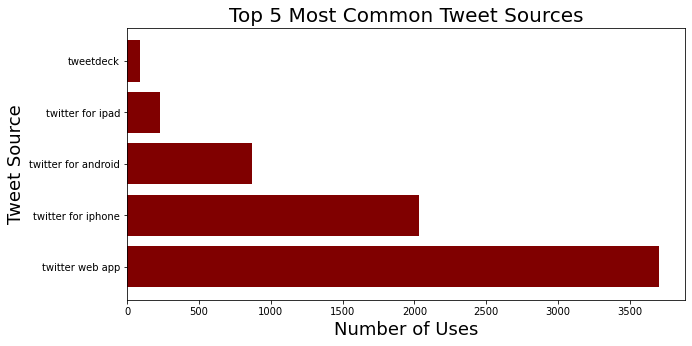

In [20]:
# This bar chart shows that by far & away, most of the tweets were generated on the twitter web app, not on a mobile device

fig = plt.figure(figsize=(10,5))
plt.barh(source_df['sources'], source_df['count'], color='maroon')
plt.xlabel('Number of Uses', fontsize=18)
plt.ylabel('Tweet Source', fontsize=18)
plt.title('Top 5 Most Common Tweet Sources', fontsize=20)
plt.show()

In [21]:
# apply the cleaning, tokenizing, & stemming

df['txt_clean'] = df['full_text'].apply(clean_text)
df['txt_tokenized'] = df['txt_clean'].apply(tokenize)
df['txt_stemmed'] = df['txt_tokenized'].apply(stem_text)
df['text_final'] = df['txt_stemmed'].apply(lambda text: ' '.join(text))

In [22]:
df.head()

,created_at,full_text,source,lang,pos,new_var,almost_sources,final_sources,txt_clean,txt_tokenized,txt_stemmed,text_final
0,Tue Nov 16 15:26:22 +0000 2021,@AmazonHelp @amazon - What is going on with P...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en,50,""">Twitter Web App</a>",twitter web app a,twitter web app,amazonhelp amazon what is going on with picku...,"[going, pickup, tracking, id, order, bajaj, ne...","[go, pickup, track, id, order, bajaj, new, sha...",go pickup track id order bajaj new shakti neo ...
1,Tue Nov 16 15:26:21 +0000 2021,RT @ShibaInuHodler: Buy #Shib before @Amazon a...,"<a href=""http://twitter.com/download/android"" ...",en,59,""">Twitter for Android</a>",twitter for android a,twitter for android,rt shibainuhodler buy shib before amazon annou...,"[rt, shibainuhodler, buy, shib, announces]","[rt, shibainuhodl, buy, shib, announc]",rt shibainuhodl buy shib announc
2,Tue Nov 16 15:26:21 +0000 2021,Gone to Pot: Welcome to the Shit Show: 7 Dirty...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en,50,""">Twitter Web App</a>",twitter web app a,twitter web app,gone to pot welcome to the shit show dirty l...,"[gone, pot, welcome, shit, show, dirty, little...","[gone, pot, welcom, shit, show, dirti, littl, ...",gone pot welcom shit show dirti littl secret c...
3,Tue Nov 16 15:26:18 +0000 2021,@ShibaInuHodler @amazon Any news update of thi...,"<a href=""http://twitter.com/download/android"" ...",en,59,""">Twitter for Android</a>",twitter for android a,twitter for android,shibainuhodler amazon any news update of this,"[shibainuhodler, news, update]","[shibainuhodl, news, updat]",shibainuhodl news updat
4,Tue Nov 16 15:26:16 +0000 2021,RT @ShibaInuHodler: Buy #Shib before @Amazon a...,"<a href=""http://twitter.com/download/android"" ...",en,59,""">Twitter for Android</a>",twitter for android a,twitter for android,rt shibainuhodler buy shib before amazon annou...,"[rt, shibainuhodler, buy, shib, announces]","[rt, shibainuhodl, buy, shib, announc]",rt shibainuhodl buy shib announc


In [23]:
# Saving all these transformations so I don't have to do them again

df.to_csv('Post_clean_Tweets.csv',encoding='utf-8',index=False)

In [24]:
# Import Dataset
df = pd.read_csv('Post_clean_Tweets.csv')
df.head()

,created_at,full_text,source,lang,pos,new_var,almost_sources,final_sources,txt_clean,txt_tokenized,txt_stemmed,text_final
0,Tue Nov 16 15:26:22 +0000 2021,@AmazonHelp @amazon - What is going on with P...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en,50,""">Twitter Web App</a>",twitter web app a,twitter web app,amazonhelp amazon what is going on with picku...,"['going', 'pickup', 'tracking', 'id', 'order',...","['go', 'pickup', 'track', 'id', 'order', 'baja...",go pickup track id order bajaj new shakti neo ...
1,Tue Nov 16 15:26:21 +0000 2021,RT @ShibaInuHodler: Buy #Shib before @Amazon a...,"<a href=""http://twitter.com/download/android"" ...",en,59,""">Twitter for Android</a>",twitter for android a,twitter for android,rt shibainuhodler buy shib before amazon annou...,"['rt', 'shibainuhodler', 'buy', 'shib', 'annou...","['rt', 'shibainuhodl', 'buy', 'shib', 'announc']",rt shibainuhodl buy shib announc
2,Tue Nov 16 15:26:21 +0000 2021,Gone to Pot: Welcome to the Shit Show: 7 Dirty...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en,50,""">Twitter Web App</a>",twitter web app a,twitter web app,gone to pot welcome to the shit show dirty l...,"['gone', 'pot', 'welcome', 'shit', 'show', 'di...","['gone', 'pot', 'welcom', 'shit', 'show', 'dir...",gone pot welcom shit show dirti littl secret c...
3,Tue Nov 16 15:26:18 +0000 2021,@ShibaInuHodler @amazon Any news update of thi...,"<a href=""http://twitter.com/download/android"" ...",en,59,""">Twitter for Android</a>",twitter for android a,twitter for android,shibainuhodler amazon any news update of this,"['shibainuhodler', 'news', 'update']","['shibainuhodl', 'news', 'updat']",shibainuhodl news updat
4,Tue Nov 16 15:26:16 +0000 2021,RT @ShibaInuHodler: Buy #Shib before @Amazon a...,"<a href=""http://twitter.com/download/android"" ...",en,59,""">Twitter for Android</a>",twitter for android a,twitter for android,rt shibainuhodler buy shib before amazon annou...,"['rt', 'shibainuhodler', 'buy', 'shib', 'annou...","['rt', 'shibainuhodl', 'buy', 'shib', 'announc']",rt shibainuhodl buy shib announc


In [25]:
# Checking to see if there are any NAN entries

count_nan = df.isnull().sum()
print(count_nan)

created_at        0
full_text         0
source            0
lang              0
pos               0
new_var           0
almost_sources    0
final_sources     0
txt_clean         0
txt_tokenized     0
txt_stemmed       0
text_final        5
dtype: int64


In [26]:
# Why are there NAN fields?

df[df.text_final.isna()]

,created_at,full_text,source,lang,pos,new_var,almost_sources,final_sources,txt_clean,txt_tokenized,txt_stemmed,text_final
295,Tue Nov 16 14:33:48 +0000 2021,I’m with @amazon,"<a href=""http://twitter.com/download/iphone"" r...",en,58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone,i m with amazon,[],[],NaN
6096,Tue Nov 16 01:42:07 +0000 2021,@Venmo I’m here,"<a href=""http://twitter.com/download/iphone"" r...",en,58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone,venmo i m here,[],[],NaN
6102,Tue Nov 16 01:37:34 +0000 2021,@Venmo @Venmo why don’t you Venmo me?,"<a href=""http://twitter.com/download/iphone"" r...",en,58,""">Twitter for iPhone</a>",twitter for iphone a,twitter for iphone,venmo venmo why don t you venmo me,[],[],NaN
6972,Mon Nov 15 23:48:38 +0000 2021,@Venmo Can I Venmo you then,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en,50,""">Twitter Web App</a>",twitter web app a,twitter web app,venmo can i venmo you then,[],[],NaN
6999,Mon Nov 15 23:48:13 +0000 2021,@Venmo Will you Venmo me then?,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en,50,""">Twitter Web App</a>",twitter web app a,twitter web app,venmo will you venmo me then,[],[],NaN


In [27]:
# It appears the entire tweet was removed as stopwords. I want to remove these 5 entries

df = df[~df.text_final.isna()]
count_nan = df.isnull().sum()
print(count_nan)

created_at        0
full_text         0
source            0
lang              0
pos               0
new_var           0
almost_sources    0
final_sources     0
txt_clean         0
txt_tokenized     0
txt_stemmed       0
text_final        0
dtype: int64


In [28]:
# Applying Vader Analysis to the text_final to get a feel for the "tone" of the data

# initializing the analyzer from Vader

analyzer = SentimentIntensityAnalyzer()

# creating 2 new columns in the dataframe applying the two functions defined above

df['Vader Sentiment'] = df['text_final'].apply(vadersentimentanalysis)
df['Vader Analysis'] = df['Vader Sentiment'].apply(vader_analysis)
df.head()

,created_at,full_text,source,lang,pos,new_var,almost_sources,final_sources,txt_clean,txt_tokenized,txt_stemmed,text_final,Vader Sentiment,Vader Analysis
0,Tue Nov 16 15:26:22 +0000 2021,@AmazonHelp @amazon - What is going on with P...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en,50,""">Twitter Web App</a>",twitter web app a,twitter web app,amazonhelp amazon what is going on with picku...,"['going', 'pickup', 'tracking', 'id', 'order',...","['go', 'pickup', 'track', 'id', 'order', 'baja...",go pickup track id order bajaj new shakti neo ...,0.4588,Neutral
1,Tue Nov 16 15:26:21 +0000 2021,RT @ShibaInuHodler: Buy #Shib before @Amazon a...,"<a href=""http://twitter.com/download/android"" ...",en,59,""">Twitter for Android</a>",twitter for android a,twitter for android,rt shibainuhodler buy shib before amazon annou...,"['rt', 'shibainuhodler', 'buy', 'shib', 'annou...","['rt', 'shibainuhodl', 'buy', 'shib', 'announc']",rt shibainuhodl buy shib announc,0.0000,Neutral
2,Tue Nov 16 15:26:21 +0000 2021,Gone to Pot: Welcome to the Shit Show: 7 Dirty...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en,50,""">Twitter Web App</a>",twitter web app a,twitter web app,gone to pot welcome to the shit show dirty l...,"['gone', 'pot', 'welcome', 'shit', 'show', 'di...","['gone', 'pot', 'welcom', 'shit', 'show', 'dir...",gone pot welcom shit show dirti littl secret c...,-0.5574,Negative
3,Tue Nov 16 15:26:18 +0000 2021,@ShibaInuHodler @amazon Any news update of thi...,"<a href=""http://twitter.com/download/android"" ...",en,59,""">Twitter for Android</a>",twitter for android a,twitter for android,shibainuhodler amazon any news update of this,"['shibainuhodler', 'news', 'update']","['shibainuhodl', 'news', 'updat']",shibainuhodl news updat,0.0000,Neutral
4,Tue Nov 16 15:26:16 +0000 2021,RT @ShibaInuHodler: Buy #Shib before @Amazon a...,"<a href=""http://twitter.com/download/android"" ...",en,59,""">Twitter for Android</a>",twitter for android a,twitter for android,rt shibainuhodler buy shib before amazon annou...,"['rt', 'shibainuhodler', 'buy', 'shib', 'annou...","['rt', 'shibainuhodl', 'buy', 'shib', 'announc']",rt shibainuhodl buy shib announc,0.0000,Neutral


In [29]:
# overall count of positive vs negative vs neutral

vader_counts = df['Vader Analysis'].value_counts()
vader_counts

Neutral     5150
Negative    1059
Positive     860
Name: Vader Analysis, dtype: int64

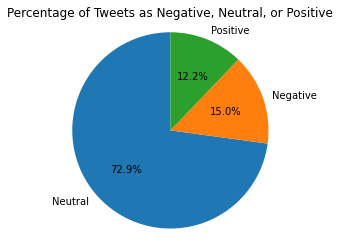

In [30]:
# Pie Chart

plt.pie(vader_counts, labels=vader_counts.index, autopct='%1.1f%%', startangle=90, 
       shadow=False)
plt.title('Percentage of Tweets as Negative, Neutral, or Positive')
plt.axis('scaled')
plt.show()

In [31]:
# Since Negative tweets are the 2nd most common in this corpus, let's look at the most common words

df_neg = df[df['Vader Analysis'] == 'Negative']
corpus = df_neg['text_final']
negative = pd.Series(' '.join(corpus).split()).value_counts()[:10]
negative

miss      508
http      503
co        503
rt        468
someon    310
day       310
beauti    301
check     265
via       249
get        70
dtype: int64

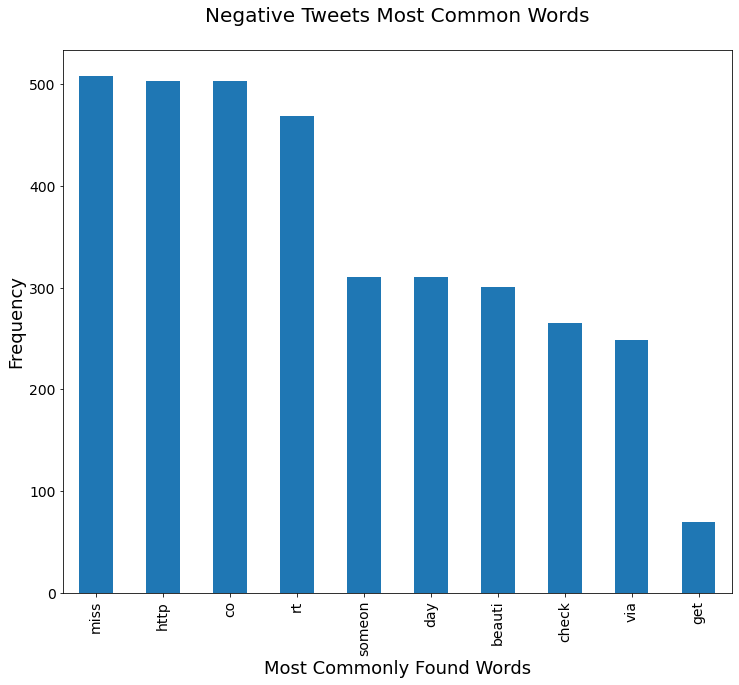

In [32]:
ax=negative.plot(kind='bar',fontsize=14,figsize=(12,10))
ax.set_title('Negative Tweets Most Common Words\n', fontsize=20)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlabel('Most Commonly Found Words', fontsize=18)
plt.show()

In [33]:
# Curious to see how positive tweets compare

df_pos = df[df['Vader Analysis'] == 'Positive']
corpus = df_pos['text_final']
positive = pd.Series(' '.join(corpus).split()).value_counts()[:10]
positive

co        657
http      650
check     384
rt        327
via       317
p         113
gift      108
amp       108
love      103
vintag     99
dtype: int64

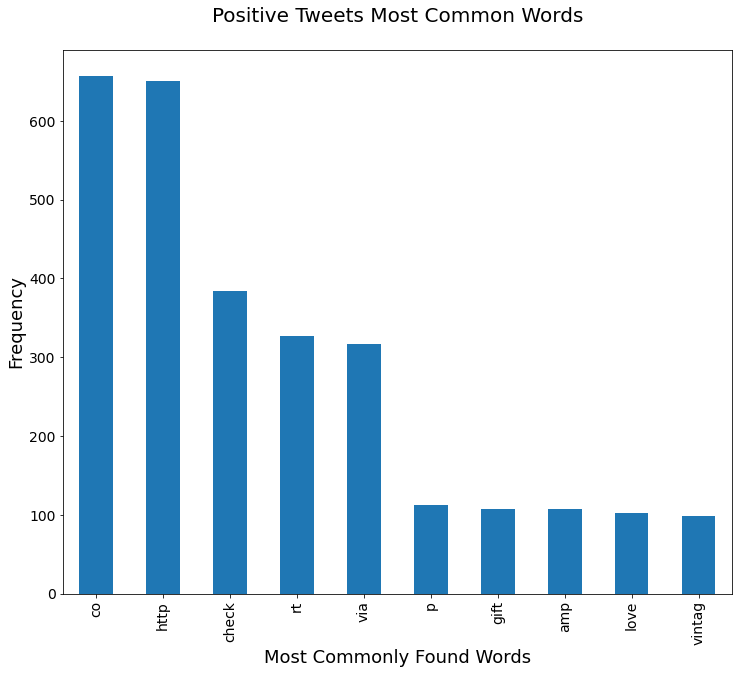

In [34]:
ax=positive.plot(kind='bar',fontsize=14,figsize=(12,10))
ax.set_title('Positive Tweets Most Common Words\n', fontsize=20)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlabel('Most Commonly Found Words', fontsize=18)
plt.show()

In [35]:
# Next, I want to see if bigrams may shed more light on the data

words = basic_clean(''.join(str(df['text_final'].tolist())))


In [36]:
bigrams = pd.Series(nltk.ngrams(words,2)).value_counts()[:12]
bigrams

(via, check)           1252
(via, rt)               747
(beauti, day)           456
(day, someon)           445
(check, vintag)         321
(someon, miss)          312
(rt, beauti)            299
(rt, shibainuhodl)      237
(buy, shib)             237
(shib, announc)         237
(shibainuhodl, buy)     235
(rt, mathmania)         213
dtype: int64

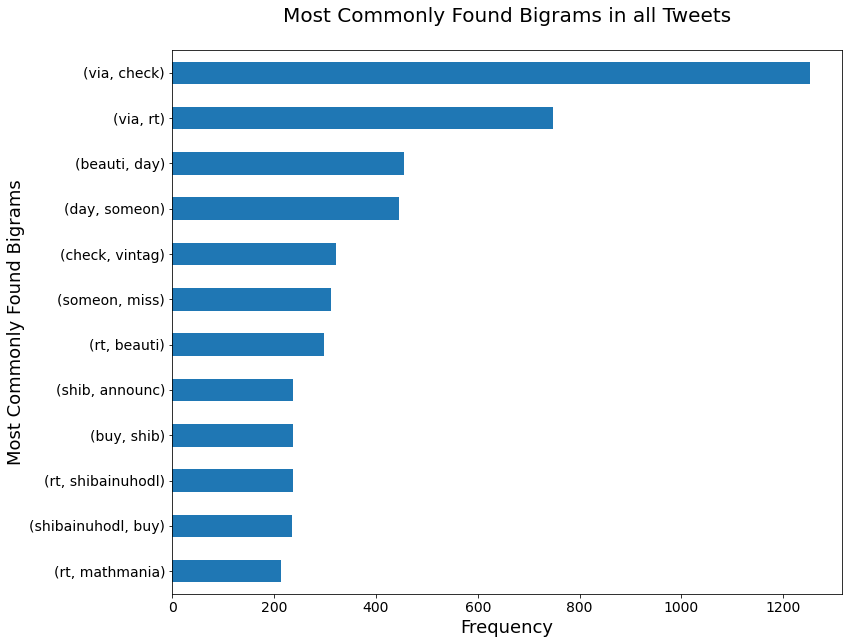

In [37]:
ax=bigrams.sort_values().plot(kind='barh',fontsize=14,figsize=(12,10))
ax.set_title('Most Commonly Found Bigrams in all Tweets\n', fontsize=20)
ax.set_ylabel('Most Commonly Found Bigrams', fontsize=18)
ax.set_xlabel('Frequency', fontsize=18)
plt.show()

# Feature Engineering

In [38]:
# checking to see what the top 3 most frequent tweet sources are:

df.final_sources.value_counts().index[:3]

Index(['twitter web app', 'twitter for iphone', 'twitter for android'], dtype='object')

In [39]:
top_3 = df.final_sources.value_counts().index[:3]

df[df.final_sources.isin(top_3)].final_sources.value_counts()

twitter web app        3698
twitter for iphone     2030
twitter for android     873
Name: final_sources, dtype: int64

In [40]:
# creating a new dataframe of just the tweets from the top 3 sources

df_top3 = df[df.final_sources.isin(top_3)]
df_top3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6601 entries, 0 to 7073
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   created_at       6601 non-null   object 
 1   full_text        6601 non-null   object 
 2   source           6601 non-null   object 
 3   lang             6601 non-null   object 
 4   pos              6601 non-null   int64  
 5   new_var          6601 non-null   object 
 6   almost_sources   6601 non-null   object 
 7   final_sources    6601 non-null   object 
 8   txt_clean        6601 non-null   object 
 9   txt_tokenized    6601 non-null   object 
 10  txt_stemmed      6601 non-null   object 
 11  text_final       6601 non-null   object 
 12  Vader Sentiment  6601 non-null   float64
 13  Vader Analysis   6601 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 773.6+ KB


In [41]:
# creating a category feature identifying the tweet source

sources_map = {
    'twitter for iphone': 1,
    'twitter for android': 2,
    'twitter web app': 0
}
df_top3['labels'] = df_top3.final_sources.map(sources_map)
df_top3['labels'] = df_top3.labels.astype('category')
df_top3.head()

C:\Users\chels\AppData\Local\Temp/ipykernel_14132/2943401873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top3['labels'] = df_top3.final_sources.map(sources_map)
C:\Users\chels\AppData\Local\Temp/ipykernel_14132/2943401873.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top3['labels'] = df_top3.labels.astype('category')


,created_at,full_text,source,lang,pos,new_var,almost_sources,final_sources,txt_clean,txt_tokenized,txt_stemmed,text_final,Vader Sentiment,Vader Analysis,labels
0,Tue Nov 16 15:26:22 +0000 2021,@AmazonHelp @amazon - What is going on with P...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en,50,""">Twitter Web App</a>",twitter web app a,twitter web app,amazonhelp amazon what is going on with picku...,"['going', 'pickup', 'tracking', 'id', 'order',...","['go', 'pickup', 'track', 'id', 'order', 'baja...",go pickup track id order bajaj new shakti neo ...,0.4588,Neutral,0
1,Tue Nov 16 15:26:21 +0000 2021,RT @ShibaInuHodler: Buy #Shib before @Amazon a...,"<a href=""http://twitter.com/download/android"" ...",en,59,""">Twitter for Android</a>",twitter for android a,twitter for android,rt shibainuhodler buy shib before amazon annou...,"['rt', 'shibainuhodler', 'buy', 'shib', 'annou...","['rt', 'shibainuhodl', 'buy', 'shib', 'announc']",rt shibainuhodl buy shib announc,0.0000,Neutral,2
2,Tue Nov 16 15:26:21 +0000 2021,Gone to Pot: Welcome to the Shit Show: 7 Dirty...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en,50,""">Twitter Web App</a>",twitter web app a,twitter web app,gone to pot welcome to the shit show dirty l...,"['gone', 'pot', 'welcome', 'shit', 'show', 'di...","['gone', 'pot', 'welcom', 'shit', 'show', 'dir...",gone pot welcom shit show dirti littl secret c...,-0.5574,Negative,0
3,Tue Nov 16 15:26:18 +0000 2021,@ShibaInuHodler @amazon Any news update of thi...,"<a href=""http://twitter.com/download/android"" ...",en,59,""">Twitter for Android</a>",twitter for android a,twitter for android,shibainuhodler amazon any news update of this,"['shibainuhodler', 'news', 'update']","['shibainuhodl', 'news', 'updat']",shibainuhodl news updat,0.0000,Neutral,2
4,Tue Nov 16 15:26:16 +0000 2021,RT @ShibaInuHodler: Buy #Shib before @Amazon a...,"<a href=""http://twitter.com/download/android"" ...",en,59,""">Twitter for Android</a>",twitter for android a,twitter for android,rt shibainuhodler buy shib before amazon annou...,"['rt', 'shibainuhodler', 'buy', 'shib', 'annou...","['rt', 'shibainuhodl', 'buy', 'shib', 'announc']",rt shibainuhodl buy shib announc,0.0000,Neutral,2


In [42]:
# create the corpus for TFIDF

corpus = df_top3['text_final'].values.astype('U')
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus)
y = df_top3['labels']

In [43]:
# Split the data into testing & training data sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [44]:
# Looking to make sure they are the same length

X_train.shape

(5280, 15670)

In [45]:
y_train.shape

(5280,)

Class=2, n=2958 (33.333%)
Class=0, n=2958 (33.333%)
Class=1, n=2958 (33.333%)


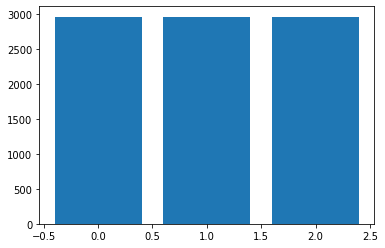

In [46]:
# Since the dataset is so varied between the top 3 (twitter web app being almost double the iphone app) I want to oversample via SMOTE

X = X_train
y = y_train

# transform the training data only

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

### Model Selection & Evaluation

In [47]:
# Now, all three tweet sources are represented equally in the training data

# fit the training data with a Random Forest Classifier

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [48]:
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)
print("ROC AUC: ", roc_auc_score(y_test, y_prob, multi_class='ovr'))
print("Classification Report:",)
print (classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test,y_pred)*100)

ROC AUC:  0.8949851763569637
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       740
           1       0.70      0.80      0.75       406
           2       0.63      0.37      0.47       175

    accuracy                           0.80      1321
   macro avg       0.74      0.69      0.70      1321
weighted avg       0.79      0.80      0.79      1321

Accuracy: 79.86373959121877


In [49]:
# fit the training dataset on the NB classifier

Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train, y_train)

# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test)

In [50]:
# Use accuracy_score function to get the accuracy

print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Accuracy Score ->  74.41332323996971
